В этой работе мы будем решать задачу музыкальной рекомендации. Наша цель — разработать модель, которая сможет предлагать каждому пользователю набор треков, наиболее похожих на те, которые он уже слушал.

В первой части работы мы сосредоточимся на memory-based подходе и модели со скрытыми переменными. Хотя эти методы не обладают высокой мощностью, они позволяют делать предсказания практически мгновенно.

Затем, во второй части, мы обратим внимание на то, что наш датасет содержит огромное количество треков. Мы будем использовать результаты уже построенных быстрых моделей для того, чтобы сузить список кандидатов до разумного размера. После этого мы проведем ранжирование среди выбранных кандидатов с помощью более сильной, но несколько более медленной модели, и отберем лучшие варианты.

In [ ]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [ ]:
!gdown --id "1svGUCsS2W3DjgKN2xYyxIQj8gkyfAEu5"
!gdown --id "19RbCaZfsirtxyKuuFt-Rp7-bTnCTEg6o"

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1svGUCsS2W3DjgKN2xYyxIQj8gkyfAEu5
To: /content/tracks_info.csv
100% 3.42M/3.42M [00:00<00:00, 116MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19RbCaZfsirtxyKuuFt-Rp7-bTnCTEg6o
To: /content/music_dataset.csv
100% 1.32M/1.32M [00:00<00:00, 32.3MB/s]


In [ ]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

Реализуем метрику $MAP@k$.

In [ ]:
def apk(relevant: List[int], predicted: List[int], k: int = 20) -> float:
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    m = 0.0

    for i, p in enumerate(predicted):
        if p in relevant and p not in predicted[:i]:
            m += 1.0
            score += m / (i + 1.0)

    return score / min(len(relevant), k)

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):

    return sum(apk(r, p, k) for r, p in zip(relevant, predicted)) / len(relevant)

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [ ]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [ ]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [ ]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [ ]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [ ]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

Реализуем класс `BaseModel` от которого будут наследоваться все последующие модели. `get_test_recommendations` принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        for user_id in range(self.n_users):
            user_recommendations = self.recommend(user_id)
            test_preds.append(user_recommendations)

        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

Реализуем функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей.

In [ ]:
def jaccard(ratings, user_vector, sparse=False):
    if sparse:
        ratings = ratings.toarray()
        user_vector = user_vector.toarray().flatten()

    intersection = np.sum((ratings == 1) & (user_vector == 1), axis=1)
    union = np.sum((ratings == 1) | (user_vector == 1), axis=1)

    similarity = intersection / (union + 1e-10)
    return similarity

Напишем класс `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        user_vector = self.R[uid]
        user_similarity = self.similarity(user_vector)

        neighbours = np.where(user_similarity > self.alpha)[0]

        scores = np.zeros(self.n_items)
        for neighbour in neighbours:
            scores += user_similarity[neighbour] * self.R[neighbour]


        unseen_items = np.where(self.R[uid] == 0)[0]
        recommendations = unseen_items[np.argsort(-scores[unseen_items])]

        return recommendations

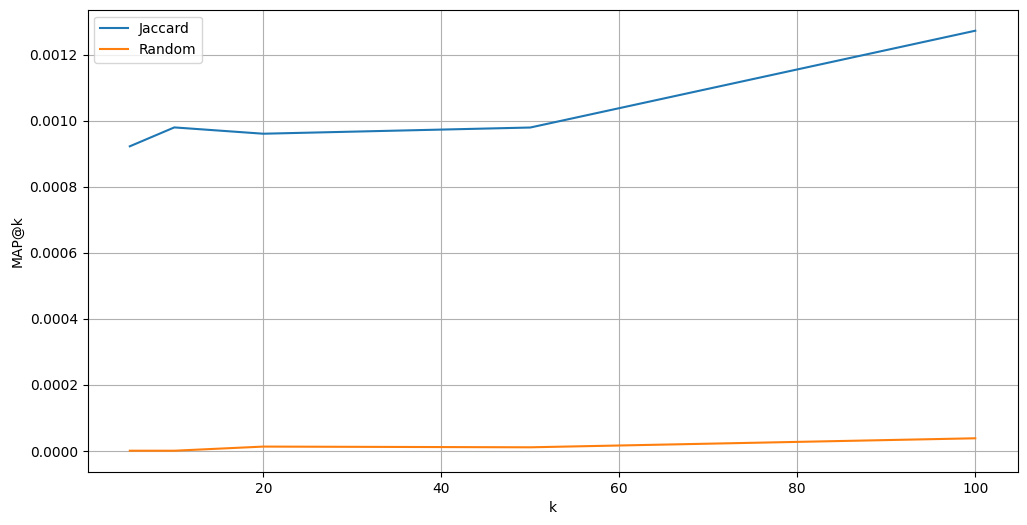

CPU times: user 1min 1s, sys: 5.12 s, total: 1min 7s
Wall time: 1min 10s


In [ ]:
%%time

class RandomModel(BaseModel):
    def recommend(self, uid: int):
        unseen_items = np.where(self.R[uid] == 0)[0]
        return np.random.permutation(unseen_items)

results = {'Jaccard': [], 'Random': []}

jaccard_model = User2User(train_ratings, jaccard)
random_model = RandomModel(train_ratings)

for k in [5, 10, 20, 50, 100]:
    jaccard_preds = jaccard_model.get_test_recommendations(k)
    random_preds = random_model.get_test_recommendations(k)

    jaccard_mapk = mapk(test_relevant, jaccard_preds, k)
    random_mapk = mapk(test_relevant, random_preds, k)

    results['Jaccard'].append(jaccard_mapk)
    results['Random'].append(random_mapk)

plt.figure(figsize=(12, 6))
plt.plot([5, 10, 20, 50, 100], results['Jaccard'], label='Jaccard')
plt.plot([5, 10, 20, 50, 100], results['Random'], label='Random')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.grid()
plt.show()

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя.

In [ ]:
user_id = np.random.randint(0, jaccard_model.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
5517,Варвара,['Би-2']
6243,Thank You,['Dido']
7767,ариведерчи,['Земфира']
11525,Stereo Hearts,"['Gym Class Heroes', 'Adam Levine']"
17348,Её глаза,['Би-2']
18235,Drunk in Love,"['Beyoncé', 'Jay-Z']"
18461,No More,"['Gorgon City', 'Liv']"
19142,Напитки покрепче,['Звери']
19157,Для тебя,['Звери']
20361,Imagination,"['Gorgon City', 'Katy Menditta']"


In [ ]:
preds = jaccard_model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
1137,Nothing Else Matters,['Metallica']
1073,Smells Like Teen Spirit,['Nirvana']
164,My Favourite Game,['The Cardigans']
2555,Californication,['Red Hot Chili Peppers']
5520,Серебро,['Би-2']
2941,Supermassive Black Hole,"['Muse', 'Matthew Bellamy', 'Dominic Howard', ..."
40390,In My Mind,"['Dynoro', ""Gigi D'Agostino""]"
41502,In the End,"['Tommee Profitt', 'Fleurie', 'Jung Youth']"
33436,Believer,['Imagine Dragons']
24500,Way Down We Go,['KALEO']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
65670,Calabria,"['Strange Fruits Music', 'DMNDS', 'Lunis', 'Fa..."
65710,Не Бруклин,"['MOT', 'LYRIQ']"
65765,Seven Nation Army,"['Strange Fruits Music', 'DMNDS', 'KOYSINA']"
65774,я не помню,['By Индия']
65812,The Way,['Dennis Lloyd']
65962,Just Dance,"['EQRIC', 'ISAEV', 'Britt Lari']"
65971,Я в моменте,"['Джарахов', 'Markul']"
65983,Strong Enough,"['Vadim Adamov', 'Hardphol']"
66013,Ты была права,['Баста']
66073,RRAK TAK TAK,"['Eri Qerimi', 'Landi Roko', 'Albert Sula']"


Получилось скорее плохо. Не вижу совпадений не то что по песням, даже по жанру :)

### Часть 2. Модель со скрытыми переменными: ALS

В этой части работы мы будем исследовать метод рекомендаций, основанный на скрытых переменных.

Идея заключается в следующем: будем предсказывать рейтинги с помощью формулы
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
где $p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ — это латентные векторы пользователя $u$ и объекта (например, трека) $i$ соответственно.

Цель оптимизации — минимизировать среднеквадратичную ошибку (MSE) между истинными оценками пользователя и предсказанными, с учетом регуляризации:
$$
L = \sum_{(u, i) \in R} (\hat{r}{ui} - r{ui})^2 + \lambda \left(\sum_{u \in U} |p_u|^2 + \sum_{i \in I} |q_i|^2\right)
$$

Примечание: Эта модель предназначена для работы с явной информацией о предпочтениях. В нашем случае модель будет стремиться возвращать значение 1, поскольку ошибка вычисляется только по парам, для которых получен фидбек. Однако, несмотря на это, модель все же имеет смысл. Благодаря случайной инициализации матриц $P$ и $Q$, обученные векторы пользователей и объектов будут различаться в конце обучения, что позволит модели делать полезные предсказания.

Дополнительное замечание: Для более эффективной работы с неявной информацией был предложен метод iALS. Его описание можно найти в лекции. В дальнейшем можно рассмотреть его реализацию для улучшения результатов.

Распишем класс для методов ALS и SGD

In [ ]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
            if self.mode == 'sgd':
               for epoch in tqdm(range(num_iters)):
                  for idx, row in self.ratings.iterrows():
                      u = row['userId']
                      i = row['trackId']
                      r_ui = self.R[u, i]

                      pred = np.dot(self.P[u], self.Q[i])
                      error = pred - r_ui

                      self.P[u] -= self.lr * (error * self.Q[i] + self.lamb * self.P[u])
                      self.Q[i] -= self.lr * (error * self.P[u] + self.lamb * self.Q[i])

            elif self.mode == 'als':
                for epoch in tqdm(range(num_iters)):
                    for u in range(self.n_users):
                        rated_items = self.ratings[self.ratings['userId'] == u]
                        Q_i = self.Q[rated_items['trackId']]
                        r_ui = self.R[u, rated_items['trackId']]
                        lambda_I = self.lamb * np.eye(self.dim)

                        self.P[u] = np.linalg.solve(
                            Q_i.T @ Q_i + lambda_I,
                            Q_i.T @ r_ui
                        )

                    for i in range(self.n_items):
                        rated_users = self.ratings[self.ratings['trackId'] == i]
                        P_u = self.P[rated_users['userId']]
                        r_ui = self.R[rated_users['userId'], i]
                        lambda_I = self.lamb * np.eye(self.dim)

                        self.Q[i] = np.linalg.solve(
                            P_u.T @ P_u + lambda_I,
                            P_u.T @ r_ui
                        )


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

In [ ]:
class RandomModel(BaseModel):
    def recommend(self, uid: int):
        unseen_items = np.where(self.R[uid] == 0)[0]
        return np.random.permutation(unseen_items)


results = {
    'SGD': {},
    'ALS': {},
    'User2User': {},
    'Random': {}
}

jaccard_model = User2User(train_ratings, jaccard)
random_model = RandomModel(train_ratings)

for num_iters in [5, 10, 20]:
    for d in [16, 32]:
        sgd_model = LatentFactorModel(train_ratings, dim=d, mode='sgd')
        als_model = LatentFactorModel(train_ratings, dim=d, mode='als')

        sgd_model.fit(num_iters)
        als_model.fit(num_iters)
        for k in [5, 10, 20]:
            sgd_preds = sgd_model.get_test_recommendations(k)
            als_preds = als_model.get_test_recommendations(k)

            sgd_mapk = mapk(test_relevant, sgd_preds, k)
            als_mapk = mapk(test_relevant, als_preds, k)

            results['SGD'][(num_iters, d, k)] = sgd_mapk
            results['ALS'][(num_iters, d, k)] = als_mapk


for k in [5, 10, 20]:
    jaccard_preds = jaccard_model.get_test_recommendations(k)
    random_preds = random_model.get_test_recommendations(k)
    jaccard_mapk = mapk(test_relevant, jaccard_preds, k)
    random_mapk = mapk(test_relevant, random_preds, k)

    results['User2User'][(1, 1, k)] = jaccard_mapk
    results['Random'][(1, 1, k)] = random_mapk

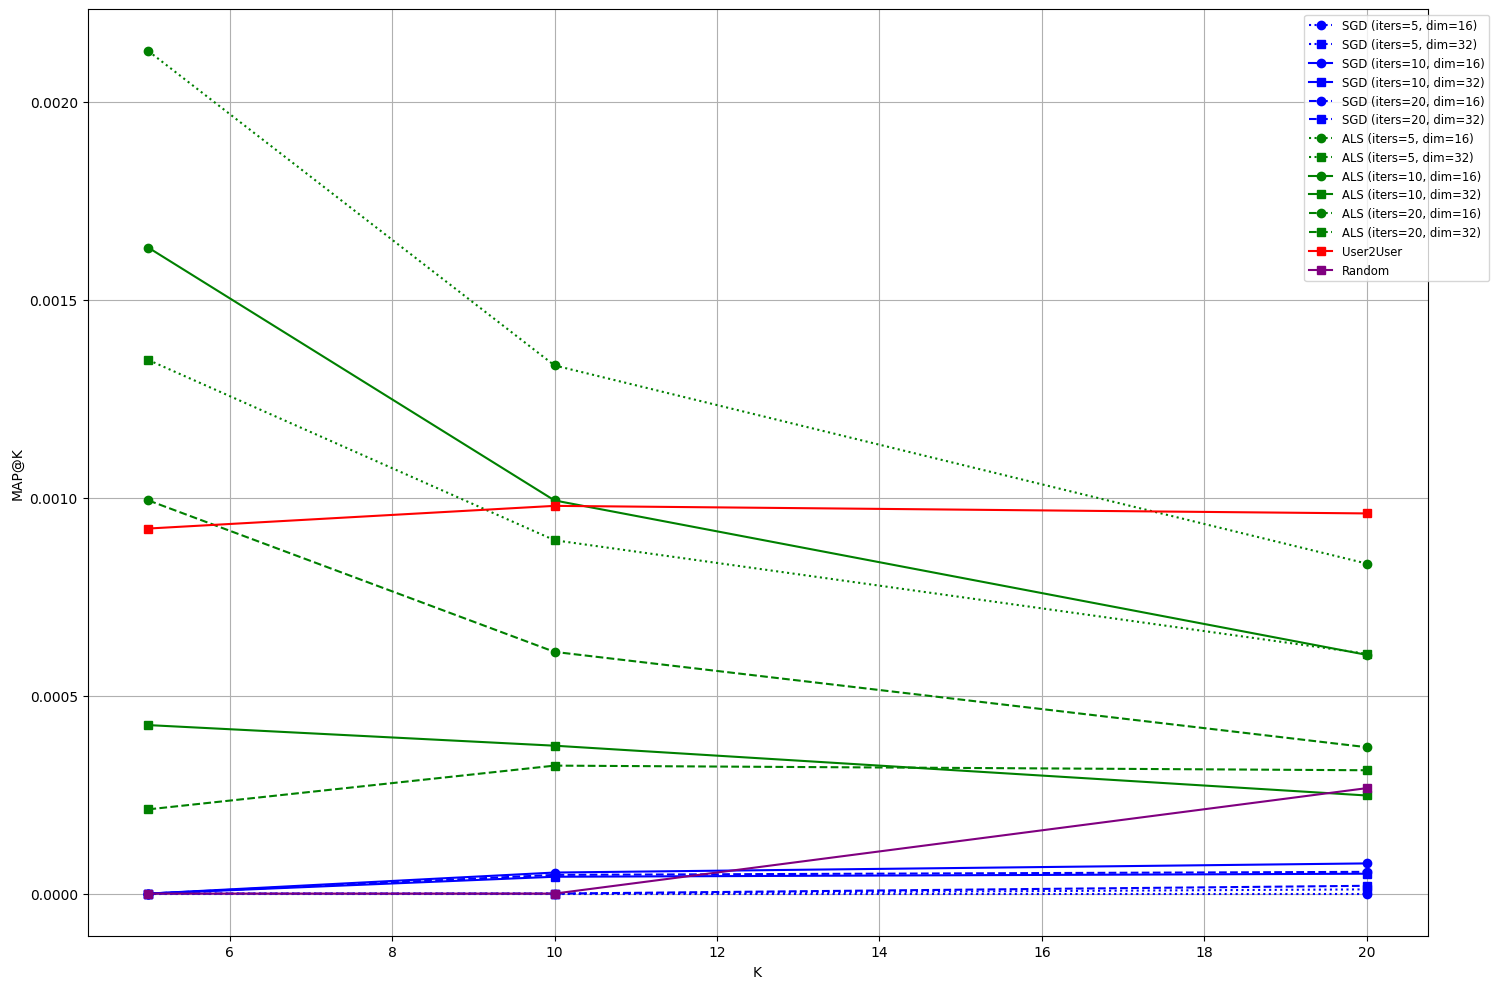

In [ ]:
plt.figure(figsize=(15, 10))

markers = ['o', 's', 'D', '^']
linestyles = ['-', '--', ':']
model_colors = {
    'SGD': 'blue',
    'ALS': 'green',
    'User2User': 'red',
    'Random': 'purple'
}

for model in ['SGD', 'ALS']:
    for num_iters in [5, 10, 20]:
        for d in [16, 32]:
            ks = sorted([k for (ni, dim, k) in results[model].keys() if ni == num_iters and dim == d])
            mapk_values = [results[model][(num_iters, d, k)] for k in ks]
            label = f'{model} (iters={num_iters}, dim={d})'
            plt.plot(ks, mapk_values, marker=markers[d // 16 - 1], linestyle=linestyles[num_iters // 10 - 1], color=model_colors[model], label=label)

for model in ['User2User', 'Random']:
    mapk_values = [results[model][(1, 1, k)] for k in [5, 10, 20]]
    label = f'{model}'
    plt.plot(ks, mapk_values, marker=markers[d // 16 - 1], linestyle='-', color=model_colors[model], label=label)

plt.xlabel('K')
plt.ylabel('MAP@K')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = als_model.Q @ als_model.Q[example_trackId]
preds = preds / np.sqrt((als_model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(als_model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2755,Snow (Hey Oh),['Red Hot Chili Peppers'],0.752380
15242,Батарейка,['Жуки'],0.750686
41637,Cumberland Gap,['David Rawlings'],0.733720
2555,Californication,['Red Hot Chili Peppers'],0.718749
5872,Я свободен,['Кипелов'],0.709711
8340,Sail,['AWOLNATION'],0.702432
1056,Don't Speak,['No Doubt'],0.698914
40600,Sid & Nancy,['Lumen'],0.696270
5521,Полковнику никто не пишет,['Би-2'],0.693807


### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью


Для каждого пользователя возьмем топ-100 рекомендованных треков от модели LFM и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [ ]:
model_als = LatentFactorModel(train_ratings, dim=32, mode='als')
model_als.fit(20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
def get_top_k_recommendations(model, k):
    recommendations = []
    for user_id in range(model.n_users):
        user_recommendations = model.recommend(user_id)[:k]
        recommendations.append((user_id, user_recommendations))
    return recommendations

top_100_u2u = get_top_k_recommendations(jaccard_model, 100)
top_100_lfm = get_top_k_recommendations(model_als, 100)

Для подготовки датасета, который будет использоваться для обучения модели ранжирования, создадим пары “объект - целевая переменная”. Объектом будет пара (пользователь, трек) с добавлением различных признаков, основанных на этой паре. Ниже приведен список признаков, которые предлагается включить в датасет. Вы также можете добавить дополнительные признаки, если они кажутся вам полезными:

	1.	Идентификатор пользователя.
	2.	Идентификатор трека.
	3.	Косинусное расстояние между эмбеддингами LFM для соответствующего пользователя и трека.
	4.	Среднее значение коэффициента Жаккара между данным пользователем и другими пользователями, полученное с помощью модели User2User.
	5.	Доля пользователей, которые слушали этот трек (основано на обучающей выборке из Части 1).
	6.	Количество треков, прослушанных пользователем (основано на обучающей выборке из Части 1).

В качестве целевой переменной будем использовать бинарную метку, которая указывает, попал ли трек в 50 последних прослушанных пользователем.

После создания датасета, разделите его на обучающую и тестовую выборки в соотношении 3:2, при этом соблюдая одинаковые пропорции положительных и отрицательных примеров в каждой из подвыборок.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as tts

def cosine_distance_matrix(P, Q):
    P_norm = P / np.linalg.norm(P, axis=1, keepdims=True)
    Q_norm = Q / np.linalg.norm(Q, axis=1, keepdims=True)
    return 1 - np.dot(P_norm, Q_norm.T)


user_last_items = ratings.groupby('userId')['trackId'].apply(lambda x: set(x.tail(50))).to_dict()
cos_distances = cosine_distance_matrix(model_als.P, model_als.Q)
item_popularity = ratings['trackId'].value_counts(normalize=True).reindex(range(jaccard_model.n_items), fill_value=0).values
user_item_count = ratings['userId'].value_counts().reindex(range(jaccard_model.n_users), fill_value=0).values
user_ids, item_ids = np.meshgrid(range(jaccard_model.n_users), range(jaccard_model.n_items), indexing='ij')

cos_dist_flat = cos_distances.flatten().astype(np.float32)
item_pop_flat = np.tile(item_popularity, jaccard_model.n_users).astype(np.float32)
user_item_count_flat = np.repeat(user_item_count, jaccard_model.n_items).astype(np.float32)
targets_flat = np.array([int(item_id in user_last_items[user_id]) for user_id, item_id in zip(user_ids.flatten(), item_ids.flatten())], dtype=np.int8)

data = np.column_stack((user_ids.flatten(), item_ids.flatten(), cos_dist_flat, item_pop_flat, user_item_count_flat, targets_flat))

df = pd.DataFrame(data, columns=['user_id', 'item_id', 'cos_dist', 'item_popularity', 'user_item_count', 'target'])
train_df, test_df = tts(df, test_size=0.4, stratify=df['target'], random_state=42)

In [ ]:
train_df = train_df.sort_values(by='user_id').reset_index(drop=True)
test_df = test_df.sort_values(by='user_id').reset_index(drop=True)
y_train = train_df["target"]
X_train = train_df.drop(["target"], axis = 1)
y_test = test_df["target"]
X_test = test_df.drop(["target"], axis = 1)

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [ ]:
!pip install catboost

In [ ]:
import catboost
train_group_id = X_train['user_id'].astype(int)
test_group_id = X_test['user_id'].astype(int)
# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=train_group_id)
test_pool = catboost.Pool(X_test, y_test, group_id=test_group_id)

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000, learning_rate=0.1, verbose=100, task_type = "GPU")
model.fit(train_pool)
preds_proba = model.predict_proba(test_pool)[:, 1]

test_df['preds_proba'] = preds_proba
recommendations_catboost = test_df.sort_values(by='preds_proba', ascending=False).groupby('user_id').head(20)

relevant_items = test_df[test_df['target'] == 1].groupby('user_id')['item_id'].apply(list).tolist()
mean_map20_catboost = mapk(relevant_items, recommendations_catboost, k=20)
print(f"MAP@20 for CatBoost: {mean_map20_catboost}")

0:	learn: 0.3596138	total: 286ms	remaining: 4m 45s
100:	learn: 0.0030849	total: 17.3s	remaining: 2m 34s
200:	learn: 0.0030066	total: 29s	remaining: 1m 55s
300:	learn: 0.0029554	total: 36.8s	remaining: 1m 25s
400:	learn: 0.0029110	total: 45.4s	remaining: 1m 7s
500:	learn: 0.0028666	total: 54.3s	remaining: 54s
600:	learn: 0.0028297	total: 1m 2s	remaining: 41.2s
700:	learn: 0.0027938	total: 1m 10s	remaining: 30.3s
800:	learn: 0.0027599	total: 1m 19s	remaining: 19.9s
900:	learn: 0.0027309	total: 1m 27s	remaining: 9.65s
999:	learn: 0.0027022	total: 1m 36s	remaining: 0us
MAP@20 for CatBoost: 0.0


In [ ]:
top_100_u2u = jaccard_model.get_test_recommendations(100)
top_100_lfm = model_als.get_test_recommendations(100)

mean_map20_u2u = mapk(relevant_items, top_100_u2u, k=20)
mean_map20_lfm = mapk(relevant_items, top_100_lfm, k=20)
print(f"MAP@20 for LFM: {mean_map20_lfm}")
print(f"CatBoost MAP@20: {mean_map20_catboost}")
print(f"User2User MAP@20: {mean_map20_u2u}")
print(f"LFM MAP@20: {mean_map20_lfm}")

MAP@20 for LFM: 3.840245775729647e-05
CatBoost MAP@20: 0.0
User2User MAP@20: 7.467144563918757e-05
LFM MAP@20: 3.840245775729647e-05


Кривовато катбустом воспользовался, либо эмбеддинги из LFM вышли не очень(скорее всего - и то, и то)